In [89]:
# Loading packages
import pandas as pd #Analysis 
import numpy as np #Analysis 

from scipy.stats import norm #Analysis 
from scipy import stats #Analysis 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler #Analysis 
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization

import xgboost as xgb
import lightgbm as lgb

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

In [90]:
df_train = pd.read_csv('../input/train.csv')
df_test  = pd.read_csv('../input/test.csv')

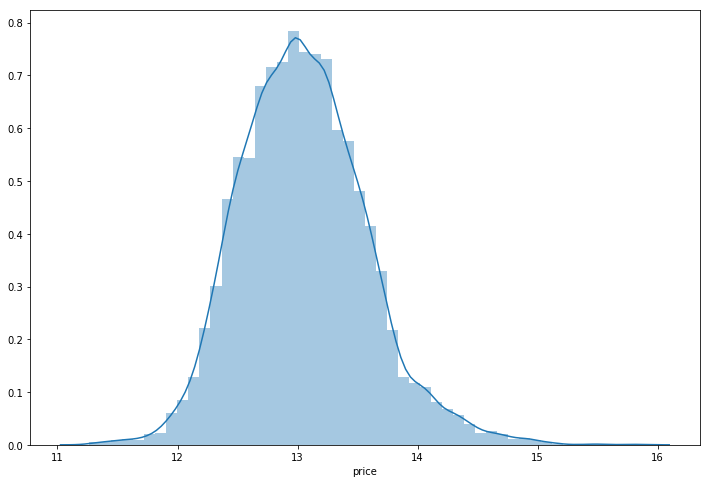

In [91]:
df_train['price'] = np.log1p(df_train['price'])
# f, ax = plt.subplots(figsize=(12, 8))
# sns.distplot(df_train['price'])

In [92]:
# 이상치 제거
df_train = df_train.loc[df_train['id']!=2775]
df_train = df_train.loc[df_train['id']!=5108]
df_train = df_train.loc[df_train['id']!=8912]

# 로그를 취하면서, 정규화
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement','sqft_living15','sqft_lot15']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

In [93]:
for df in [df_train,df_test]:
    
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    # 총 넓이
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 지하실 여부
    df['underground'] = df['sqft_basement'].apply(lambda x : 1  if x > 0  else 0)
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부     
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)

In [94]:
y_train = df_train.price
x_train = df_train.drop(['id','price'], axis=1)
x_test = df_test.drop(['id'], axis=1)

index = df_train.shape[0]
df = pd.concat([x_train, x_test], axis=0)

In [95]:
# 연도별 , 달별 변수 생성
year = df.date.apply(lambda x: x[0:4]).astype(int)
month = df.date.apply(lambda x: x[4:6]).astype(int)
day = df.date.apply(lambda x: x[6:8]).astype(int)

df['year_month'] = year*100 + month
df['month_day'] = month*100 + day
df['ym_freq'] = df.groupby('year_month')['year_month'].transform('count')
df['md_freq'] = df.groupby('month_day')['month_day'].transform('count')

df = df.drop(['date'], axis=1)

In [96]:
df['zipcode-3'] = 'z_' + df['zipcode'].astype(str).str[2]
df['zipcode-4'] = 'z_' + df['zipcode'].astype(str).str[3]
df['zipcode-5'] = 'z_' + df['zipcode'].astype(str).str[4]

df['zipcode-34'] = 'z_' + df['zipcode'].astype(str).str[2:4]
df['zipcode-45'] = 'z_' + df['zipcode'].astype(str).str[3:5]
df['zipcode-35'] = 'z_' + df['zipcode'].astype(str).str[2:3] + df['zipcode'].astype(str).str[4:5]

In [97]:
print(df.shape)
df.head()

(21500, 35)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,underground,sqft_ratio_1,sqft_ratio15,is_renovated,year_month,month_day,ym_freq,md_freq,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35
0,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,7.201171,8.639588,4.00,0.818803,7.074117,0,1.0,0.833509,0,201410,1013,1872,62,z_1,z_7,z_8,z_17,z_78,z_18
1,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,7.908755,8.995041,3.00,0.721756,6.647688,0,1.0,0.879235,0,201502,225,1234,92,z_0,z_2,z_8,z_02,z_28,z_08
2,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,7.496097,8.923191,5.00,0.825489,7.427144,0,1.0,0.840069,0,201502,218,1234,86,z_0,z_7,z_4,z_07,z_74,z_04
3,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,7.713785,8.827615,5.25,0.843688,7.447751,0,1.0,0.873824,0,201406,627,2179,92,z_0,z_0,z_3,z_00,z_03,z_03
4,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,7.409136,9.181118,4.50,0.758837,6.966967,0,1.0,0.806997,0,201501,115,969,45,z_1,z_9,z_8,z_19,z_98,z_18


In [ ]:
# df['zipcode'] = 'z_' + df['zipcode'].astype(str)

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='long', y='lat', hue='zipcode', hue_order=np.sort(df['zipcode'].unique()), data=df);

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='long', y='lat', hue='zipcode-3', hue_order=np.sort(df['zipcode-3'].unique()), data=df);

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='long', y='lat', hue='zipcode-4', hue_order=np.sort(df['zipcode-4'].unique()), data=df);

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='long', y='lat', hue='zipcode-5', hue_order=np.sort(df['zipcode-5'].unique()), data=df);

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='long', y='lat', hue='zipcode-34', hue_order=np.sort(df['zipcode-34'].unique()), data=df);

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='long', y='lat', hue='zipcode-45', hue_order=np.sort(df['zipcode-45'].unique()), data=df);

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='long', y='lat', hue='zipcode-35', hue_order=np.sort(df['zipcode-35'].unique()), data=df);

In [ ]:
RANDOM_SEED = 100
inertia_arr = []

k_range = range(2,50)

for k in k_range:
    kmeans = KMeans(n_clusters=k,random_state=RANDOM_SEED).fit(df[['lat','long']])
 
    # Sum of distances of samples to their closest cluster center
    interia = kmeans.inertia_
    print ("k:",k, " cost:", interia)
    inertia_arr.append(interia)
    
inertia_arr = np.array(inertia_arr)

plt.plot(k_range, inertia_arr)
plt.vlines(10, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

In [98]:
# kmeans for lat, long
kmeans = KMeans(n_clusters=10, random_state=RANDOM_SEED).fit(df[['lat','long']])
cluster = kmeans.predict(df[['lat','long']])
df['geo_cluster'] = cluster
df['geo_cluster'] = df['geo_cluster'].map(lambda x: 'c_' + str(x).rjust(2, '0'))

In [ ]:
sns.scatterplot(x='long', y='lat', hue='geo_cluster', hue_order=np.sort(df['geo_cluster'].unique()), data=df);

In [99]:
df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,underground,sqft_ratio_1,sqft_ratio15,is_renovated,year_month,month_day,ym_freq,md_freq,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35,geo_cluster
0,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,7.201171,8.639588,4.00,0.818803,7.074117,0,1.0,0.833509,0,201410,1013,1872,62,z_1,z_7,z_8,z_17,z_78,z_18,c_09
1,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,7.908755,8.995041,3.00,0.721756,6.647688,0,1.0,0.879235,0,201502,225,1234,92,z_0,z_2,z_8,z_02,z_28,z_08,c_04
2,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,7.496097,8.923191,5.00,0.825489,7.427144,0,1.0,0.840069,0,201502,218,1234,86,z_0,z_7,z_4,z_07,z_74,z_04,c_06
3,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,7.713785,8.827615,5.25,0.843688,7.447751,0,1.0,0.873824,0,201406,627,2179,92,z_0,z_0,z_3,z_00,z_03,z_03,c_00
4,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,7.409136,9.181118,4.50,0.758837,6.966967,0,1.0,0.806997,0,201501,115,969,45,z_1,z_9,z_8,z_19,z_98,z_18,c_00


In [100]:
bin_labels = ['zipcode', 'zipcode-3', 'zipcode-4', 'zipcode-5', 'zipcode-34', 'zipcode-45', 'zipcode-35', 'geo_cluster']

for label in bin_labels:
    le = LabelEncoder().fit(df[label])
    df[label] = le.transform(df[label])

In [101]:
x_test.isnull().sum()

date               0
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
floors             0
waterfront         0
view               0
condition          0
grade              0
sqft_above         0
sqft_basement      0
yr_built           0
yr_renovated       0
zipcode            0
lat                0
long               0
sqft_living15      0
sqft_lot15         0
total_rooms        0
sqft_ratio         0
sqft_total_size    0
underground        0
sqft_ratio_1       0
sqft_ratio15       0
is_renovated       0
dtype: int64

In [104]:
x_train = df.iloc[:index, :] # 변환
x_test = df.iloc[index:, :] #변환

x_train.shape, x_test.shape, y_train.shape

((15032, 36), (6468, 36), (15032,))

Transform DMatrix...
Start Cross Validation...
[0]	train-rmse:12.4333	test-rmse:12.4332
[50]	train-rmse:7.52878	test-rmse:7.52889
[100]	train-rmse:4.56235	test-rmse:4.56253
[150]	train-rmse:2.7689	test-rmse:2.76925
[200]	train-rmse:1.68556	test-rmse:1.68631
[250]	train-rmse:1.03287	test-rmse:1.03457
[300]	train-rmse:0.642207	test-rmse:0.645575
[350]	train-rmse:0.412197	test-rmse:0.418371
[400]	train-rmse:0.281679	test-rmse:0.291667
[450]	train-rmse:0.212074	test-rmse:0.226256
[500]	train-rmse:0.177157	test-rmse:0.195078
[550]	train-rmse:0.159872	test-rmse:0.180715
[600]	train-rmse:0.150866	test-rmse:0.173962
[650]	train-rmse:0.14546	test-rmse:0.170436
[700]	train-rmse:0.141498	test-rmse:0.168218
[750]	train-rmse:0.138354	test-rmse:0.166693
[800]	train-rmse:0.135586	test-rmse:0.165528
[850]	train-rmse:0.133072	test-rmse:0.164572
[900]	train-rmse:0.130735	test-rmse:0.163797
[950]	train-rmse:0.128541	test-rmse:0.163125
[1000]	train-rmse:0.126515	test-rmse:0.162546
[1050]	train-rmse:0.1246

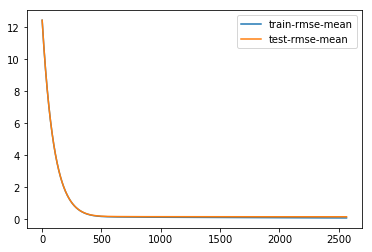

In [105]:
xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

print('Transform DMatrix...')
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=20,verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

In [106]:
model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = np.exp(model.predict(dtest))

sub = df_test[['id']]
sub['price'] = preds

sub.to_csv('sub_xgb0419.csv', index=False)

In [107]:
sub.head()

,id,price
0,15035,5.380088e+05
1,15036,4.808236e+05
2,15037,1.380275e+06
3,15038,3.051743e+05
4,15039,3.230555e+05
